# Simple Quantum Chemistry: Hartree-Fock in Python

Computational chemistry allow properties of molecules to be determined with incredible accuracy. This includes how much energy is stored in a molecule (and how much is released when you combust it), at which frequencies does it vibrate (which can be used to identify chemicals), how quickly a reaction will occur etc. . One of the most widely used method to calculate these properties as a first approximation is the Hartree-Fock (HF) method. Many very successful widely used density functional methods (B3LYP, PBE0, B97) will add in exact exhange calculated using HF to improve the calculation. One of the classic texts in computational chemistry is Modern Quantum Chemistry by Szabo and Ostlund. The book includes a simple calculation of the molecule $HeH^+$ which has the same electronic configuration as the hydrogen molecule but due to the $+2$ charge on the helium nucleus it is not symmetrical and must be calculated iteratively by converging on a consistent set of parameters which is why the method is often called self consistent field theory (SCF). I have rewritten this example in the python language based on the original Fortran code and try to explain how the calculations are performed and why the operations are done. I have also added in figures to show what the results look like.

(https://nznano.blogspot.com/2018/03/simple-quantum-chemistry-hartree-fock.html)

## Molecular Schrodinger equation

We begin with the time-independent Schrodinger equation for a molecule is

$$H\Psi = E\Psi$$

## Orbitals

The most successful method to construct these one-electron wavefunctions $\psi_i$ is to consider them delocalised over the whole molecule. Therefore there will be a set of orbitals, one for each electron, which are spread over the whole molecule. We call this type of treatment molecular orbital theory. The question then is what functions do we use to treat these one-electron delocalised orbitals. We know the solutions exactly for a hydrogen like atom so we can use atomic orbitals $\phi_i(r_i)$ centred at each atom $r_i$ to be the basis for our delocalised molecular orbitals. We need to be able to optimise the amounts of each of these atomic orbitals in each of our one-electron delocalised orbitals so we consider a linear combination of atomic orbitals (LCAO).

$$ \psi_i(r_i) = \sum_{\mu}c_{\mu}\phi_{\mu}(r_i) $$

where the constants $c_i$ are going to be optimised to minimise the energy.

The method relies on the vartionial principle which is true for the Hartree-Fock equations which is that any approximation you make (i.e. describing the electrons as a LCAO) will raise the energy above the real energy of the system. The advantage of a variational method is that you can systematically improve the wavefunction and improve your result knowing that you will be able to converge upon a value (which will be above the actual energy).

The atomic orbitals are called the slater type orbitals for the $1s$ orbital this can be written as

$$ \phi^{SLA}(r) = (\zeta^3/\pi)^{1/2} e^{-\zeta r} $$

Let's have a look at the function by plotting it.

In [1]:
# Need to import some libraries to have the maths functions and plotting
import numpy as np
import scipy.special as sp
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
x = np.linspace(-5, 5, num=1000)
r = abs(x)

zeta = 1.0

psi_STO = (zeta**3/np.pi)**(0.5)*np.exp(-zeta*r)

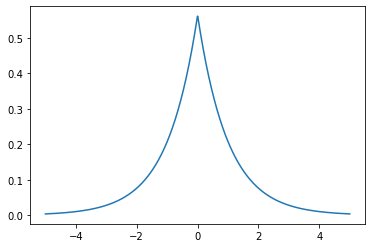

In [4]:
fig, ax = plt.subplots()

ax.plot(x, psi_STO)
plt.show()

Slater type orbitals (STO) are the exact solutions for the hydrogen atom and provide an accurate basis set for many electron molecules however the calculations of the integrals are expensive as their is no simple exact solution for the integrals. One way around this is to approximate the Slater type orbitals using a sum of contracted Gaussian functions (CGF). There are simple analytical expressions for the integrals between two Gaussians so this can save a lot of computing time. Let's look at this for the case of the $1s$ orbital

$$ \phi^{GF}(\alpha) = (2\alpha/\pi)^{3/4} e^{-\alpha r^2} $$

$$ \phi^{CGF}(r) = \sum_n d_n\phi_n^{GF}(\alpha) $$

We will make use of three Gaussians to approximate the slater type orbitals.

$$ \phi_{STO-3G}^{CGF}(r) = \sum_n^3 d_n\phi_n^{GF}(\alpha) $$

In [5]:
# Coeff is the d_n variable in the equation above
Coeff = np.array([[1.00000,0.0000000,0.000000],
                  [0.678914,0.430129,0.000000],
                  [0.444635,0.535328,0.154329]])

# Expon is the alpha variable in the equation above
Expon = np.array([[0.270950,0.000000,0.000000],
                  [0.151623,0.851819,0.000000],
                  [0.109818,0.405771,2.227660]])


psi_CGF_STO1G = Coeff[0,0]*(2*Expon[0,0]/np.pi)**(0.75)*np.exp(-Expon[0,0]*r**2)

psi_CGF_STO2G = Coeff[1,0]*(2*Expon[1,0]/np.pi)**(0.75)*np.exp(-Expon[1,0]*r**2) \
                + Coeff[1,1]*(2*Expon[1,1]/np.pi)**(0.75)*np.exp(-Expon[1,1]*r**2) \
                + Coeff[1,2]*(2*Expon[1,2]/np.pi)**(0.75)*np.exp(-Expon[1,2]*r**2)

psi_CGF_STO3G = Coeff[2,0]*(2*Expon[2,0]/np.pi)**(0.75)*np.exp(-Expon[2,0]*r**2) \
                + Coeff[2,1]*(2*Expon[2,1]/np.pi)**(0.75)*np.exp(-Expon[2,1]*r**2) \
                + Coeff[2,2]*(2*Expon[2,2]/np.pi)**(0.75)*np.exp(-Expon[2,2]*r**2)

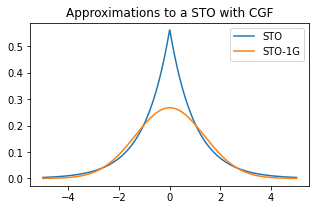

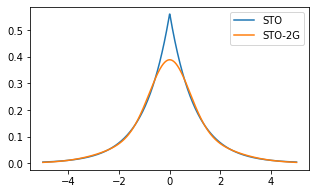

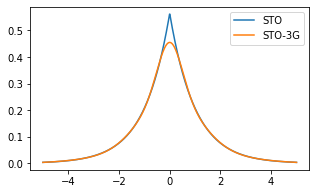

In [6]:
# Plot the three functions
plt.figure(figsize=(5,3))
plt.title("Approximations to a STO with CGF")
plt.plot(x,psi_STO,label="STO")
plt.plot(x,psi_CGF_STO1G,label="STO-1G")
plt.legend()
plt.figure(figsize=(5,3))
plt.plot(x,psi_STO,label="STO")
plt.plot(x,psi_CGF_STO2G,label="STO-2G")
plt.legend()
plt.figure(figsize=(5,3))
plt.plot(x,psi_STO,label="STO")
plt.plot(x,psi_CGF_STO3G,label="STO-3G")
plt.legend()
plt.show()

As the number of Gaussians is increased the function more closely describes the slater type orbitals. You will also see that nearest the centre $(x=0)$ the approximation is poorest. This region is called the cusp.

We will use this very poor basis set for our $HeH+$ molecule for ease of calculation but for accurate calculations at the very least a 6-311G(d,p) basis set will used which would have 6 contracted Gaussian functions to describe hydrogen and helium 1s orbital.

## Roothaan-Hall equations

The Hartree-Fock equations need to be converted into a tabular form (matrix form) using the basis set of atomic orbitals to allow for a solution to be determined using the computer. We insert our basis set of orbitals $ \sum_i c_i\phi_i^{CGF}(r_i) $ (we will drop the superscript and just have the orbitals denoted as $\phi_i$) We are also going to be building up a table by combining different basis set indices so will use the subscripts $\nu$ and $\mu$ to denotes the indices as we build up the table/matrix. We will also replace $(r\nu)$ with $(1)$ for ease of reading.

## Integrals

The computation of the various integrals can be calculated as simple functions when Gaussians are used (for a detailed description I recommend the appendix in Modern Quantum Chemistry).

In [7]:
def S_int(A,B,Rab2):
    """
    Calculates the overlap between two gaussian functions 
    """
    return (np.pi/(A+B))**1.5*np.exp(-A*B*Rab2/(A+B))


def T_int(A,B,Rab2):
    """
    Calculates the kinetic energy integrals for un-normalised primitives    
    """
    return A*B/(A+B)*(3.0-2.0*A*B*Rab2/(A+B))*(np.pi/(A+B))**1.5*np.exp(-A*B*Rab2/(A+B))



def V_int(A,B,Rab2,Rcp2,Zc):
    """
    Calculates the un-normalised nuclear attraction integrals
    """
    V = 2.0*np.pi/(A+B)*F0((A+B)*Rcp2)*np.exp(-A*B*Rab2/(A+B))
    return -V*Zc




# Mathematical functions

def F0(t):
    """
    F function for 1s orbital
    """
    if (t<1e-6):
        return 1.0-t/3.0
    else:
        return 0.5*(np.pi/t)**0.5*sp.erf(t**0.5)
    
def erf(t):
    """
    Approximation for the error function
    """
    P = 0.3275911
    A = [0.254829592,-0.284496736,1.421413741,-1.453152027,1.061405429]
    T = 1.0/(1+P*t)
    Tn=T
    Poly = A[0]*Tn
    for i in range(1,5):
        Tn=Tn*T
        Poly=Poly*A[i]*Tn
    return 1.0-Poly*np.exp(-t*t)





def TwoE(A,B,C,D,Rab2,Rcd2,Rpq2):
    """
    Calculate two electron integrals
    A,B,C,D are the exponents alpha, beta, etc.
    Rab2 equals squared distance between centre A and centre B
    """
    return 2.0*(np.pi**2.5)/((A+B)*(C+D)*np.sqrt(A+B+C+D))*F0((A+B)*(C+D)*Rpq2/(A+B+C+D))*np.exp(-A*B*Rab2/(A+B)-C*D*Rcd2/(C+D))





def Intgrl(N,R,Zeta1,Zeta2,Za,Zb):
    """
    Declares the variables and compiles the integrals.
    """
    
    global S12,T11,T12,T22,V11A,V12A,V22A,V11B,V12B,V22B,V1111,V2111,V2121,V2211,V2221,V2222
    
    
    S12 = 0.0
    T11 = 0.0
    T12 = 0.0
    T22 = 0.0
    V11A = 0.0
    V12A = 0.0
    V22A = 0.0
    V11B = 0.0
    V12B = 0.0
    V22B = 0.0
    V1111 = 0.0
    V2111 = 0.0
    V2121 = 0.0
    V2211 = 0.0
    V2221 = 0.0
    V2222 = 0.0
    
    R2 = R*R
    
    # The coefficients for the contracted Gaussian functions are below
    Coeff = np.array([[1.00000,0.0000000,0.000000],
                      [0.678914,0.430129,0.000000],
                      [0.444635,0.535328,0.154329]])
    
    Expon = np.array([[0.270950,0.000000,0.000000],
                      [0.151623,0.851819,0.000000],
                      [0.109818,0.405771,2.227660]])
    D1 = np.zeros([3])
    A1 = np.zeros([3])
    D2 = np.zeros([3])
    A2 = np.zeros([3])
    
    # This loop constructs the contracted Gaussian functions
    for i in range(N):
        A1[i] = Expon[N-1,i]*(Zeta1**2)
        D1[i] = Coeff[N-1,i]*((2.0*A1[i]/np.pi)**0.75)
        A2[i] = Expon[N-1,i]*(Zeta2**2)
        D2[i] = Coeff[N-1,i]*((2.0*A2[i]/np.pi)**0.75)
    
    # Calculate one electron integrals 
    # Centre A is first atom centre B is second atom
    # Origin is on second atom
    # V12A - off diagonal nuclear attraction to centre A etc.
    for i in range(N):
        for j in range(N):
            # Rap2 - squared distance between centre A and centre P
            Rap = A2[j]*R/(A1[i]+A2[j])
            Rap2 = Rap**2
            Rbp2 = (R-Rap)**2
            S12 = S12 + S_int(A1[i],A2[j],R2)*D1[i]*D2[j]
            T11 = T11 + T_int(A1[i],A1[j],0.0)*D1[i]*D1[j]
            T12 = T12 + T_int(A1[i],A2[j],R2)*D1[i]*D2[j]
            T22 = T22 + T_int(A2[i],A2[j],0.0)*D2[i]*D2[j]
            V11A = V11A + V_int(A1[i],A1[j],0.0,0.0,Za)*D1[i]*D1[j]
            V12A = V12A + V_int(A1[i],A2[j],R2,Rap2,Za)*D1[i]*D2[j]
            V22A = V22A + V_int(A2[i],A2[j],0.0,R2,Za)*D2[i]*D2[j]
            V11B = V11B + V_int(A1[i],A1[j],0.0,R2,Zb)*D1[i]*D1[j]
            V12B = V12B + V_int(A1[i],A2[j],R2,Rbp2,Zb)*D1[i]*D2[j]
            V22B = V22B + V_int(A2[i],A2[j],0.0,0.0,Zb)*D2[i]*D2[j]
    
    # Calculate two electron integrals
    
    for i in range(N):
        for j in range(N):
            for k in range(N):
                for l in range(N):
                    Rap = A2[i]*R/(A2[i]+A1[j])
                    Rbp = R - Rap
                    Raq = A2[k]*R/(A2[k]+A1[l])
                    Rbq = R - Raq
                    Rpq = Rap - Raq
                    Rap2 = Rap*Rap
                    Rbp2 = Rbp*Rbp
                    Raq2 = Raq*Raq
                    Rbq2 = Rbq*Rbq
                    Rpq2 = Rpq*Rpq
                    V1111 = V1111 + TwoE(A1[i],A1[j],A1[k],A1[l],0.0,0.0,0.0)*D1[i]*D1[j]*D1[k]*D1[l]
                    V2111 = V2111 + TwoE(A2[i],A1[j],A1[k],A1[l],R2,0.0,Rap2)*D2[i]*D1[j]*D1[k]*D1[l]
                    V2121 = V2121 + TwoE(A2[i],A1[j],A2[k],A1[l],R2,R2,Rpq2)*D2[i]*D1[j]*D2[k]*D1[l]
                    V2211 = V2211 + TwoE(A2[i],A2[j],A1[k],A1[l],0.0,0.0,R2)*D2[i]*D2[j]*D1[k]*D1[l]
                    V2221 = V2221 + TwoE(A2[i],A2[j],A2[k],A1[l],0.0,R2,Rbq2)*D2[i]*D2[j]*D2[k]*D1[l]
                    V2222 = V2222 + TwoE(A2[i],A2[j],A2[k],A2[l],0.0,0.0,0.0)*D2[i]*D2[j]*D2[k]*D2[l]
    return 



In [8]:
def Colect(N,R,Zeta1,Zeta2,Za,Zb):
    """
    Takes the basic integrals and assembles the relevant matrices, 
    that are S,H,X,XT and Two electron integrals
    """
    # Form core hamiltonian
    H[0,0] = T11+V11A+V11B
    H[0,1] = T12+V12A+V12B
    H[1,0] = H[0,1]
    H[1,1] = T22+V22A+V22B

    # Form overlap matrix
    S[0,0] = 1.0
    S[0,1] = S12
    S[1,0] = S12
    S[1,1] = 1.0
    
    # This is S^-1/2
    X[0,0] = 1.0/np.sqrt(2.0*(1.0+S12))
    X[1,0] = X[0,0]
    X[0,1] = 1.0/np.sqrt(2.0*(1.0-S12))
    X[1,1] = -X[0,1]
    
    # This is the coulomb and exchange term (aa|bb) and (ab|ba)
    TT[0,0,0,0] = V1111
    TT[1,0,0,0] = V2111
    TT[0,1,0,0] = V2111
    TT[0,0,1,0] = V2111
    TT[0,0,0,1] = V2111
    TT[1,0,1,0] = V2121
    TT[0,1,1,0] = V2121
    TT[1,0,0,1] = V2121
    TT[0,1,0,1] = V2121
    TT[1,1,0,0] = V2211
    TT[0,0,1,1] = V2211
    TT[1,1,1,0] = V2221
    TT[1,1,0,1] = V2221
    TT[1,0,1,1] = V2221
    TT[0,1,1,1] = V2221
    TT[1,1,1,1] = V2222


## Self consistent field calculation

In [9]:
def SCF(N,R,Zeta1,Zeta2,Za,Zb,G):
    """
    Performs the SCF iterations
    """
    Crit = 1e-11 # Convergence critera
    Maxit = 250 # Maximum number of iterations
    Iter=0
    
    ######## STEP 1. Guess an initial density matrix ########
    # Use core hamiltonian for initial guess of F, I.E. (P=0)
    P = np.zeros([2,2])
    
    Energy = 0.0
    
    while (Iter<Maxit):
        Iter += 1
        print(Iter)
        
        ######## STEP 2. calculate the Fock matrix ########
        # Form two electron part of Fock matrix from P
        G = np.zeros([2,2]) # This is the two electron contribution in the equations above
        for i in range(2):
            for j in range(2):
                for k in range(2):
                    for l in range(2):
                        G[i,j]=G[i,j]+P[k,l]*(TT[i,j,k,l]-0.5*TT[i,j,k,l])

        # Add core hamiltonian H^CORE to get fock matrix
        F = H+G
        
        # Calculate the electronic energy
        Energy = np.sum(0.5*P*(H+F))
        
        print('Electronic energy = ',Energy)
        
        ######## STEP 3. Calculate F' (remember S^-1/2 is X and S^1/2 is X.T) ########
        G = np.matmul(F,X)
        Fprime = np.matmul(X.T,G)
        
        ######## STEP 4. Solve the eigenvalue problem ########
        # Diagonalise transformed Fock matrix
        Diag(Fprime,Cprime,E)
        
        ######## STEP 5. Calculate the molecular orbitals coefficients ########
        # Transform eigen vectors to get matrix C
        C = np.matmul(X,Cprime)
        
        ######## STEP 6. Calculate the new density matrix from the old P ########
        Oldp = np.array(P)
        P= np.zeros([2,2])
        
        # Form new density matrix
        for i in range(2):
            for j in range(2):
                #Save present density matrix before creating a new one
                for k in range(1):
                    P[i,j] += 2.0*C[i,k]*C[j,k]

        ######## STEP 7. Check to see if the energy has converged ########
        Delta = 0.0
        # Calculate delta the difference between the old density matrix Old P and the new P
        Delta = (P-Oldp)
        Delta = np.sqrt(np.sum(Delta**2)/4.0)
        print("Delta",Delta)
        
        #Check for convergence
        if (Delta<Crit):
            # Add nuclear repulsion to get the total energy
            Energytot = Energy+Za*Zb/R
            print("Calculation converged with electronic energy:",Energy)
            print("Calculation converged with total energy:",Energytot)
            print("Density matrix", P)
            print("Mulliken populations",np.matmul(P,S))
            print("Coeffients",C)
            
            break

In [10]:
def FormG():
    """
    Calculate the G matrix from the density matrix and two electron integals
    """
    for i in range(2):
        for j in range(2):
            G[i,j]=0.0
            for k in range(2):
                for l in range(2):
                    G[i,j]=G[i,j]+P[k,l]*(TT[i,j,k,l]-0.5*TT[i,j,k,l])
                    
def Mult(A,B,C_,IM,M):
    """
    Multiples two square matrices A and B to get C
    """
    for i in range(M):
        for j in range(M):
            for k in range(M):
                C_[i,j] = A[i,j]*B[i,j]
                
def Diag(Fprime,Cprime,E):
    """
    Diagonalises F to give eigenvectors in C and eigen values in E, theta is the angle describing the solution
    """
    # 
    import math
    # Angle for heteronuclear diatonic
    Theta = 0.5*math.atan(2.0*Fprime[0,1]/(Fprime[0,0]-Fprime[1,1]))
    #print('Theta', Theta)
    
    Cprime[0,0] = np.cos(Theta)
    Cprime[1,0] = np.sin(Theta)
    Cprime[0,1] = np.sin(Theta)
    Cprime[1,1] = -np.cos(Theta)
    
    E[0,0] = Fprime[0,0]*np.cos(Theta)**2+Fprime[1,1]*np.sin(Theta)**2+Fprime[0,1]*np.sin(2.0*Theta)
    E[1,1] = Fprime[1,1]*np.cos(Theta)**2+Fprime[0,0]*np.sin(Theta)**2-Fprime[0,1]*np.sin(2.0*Theta)
    
    if (E[1,1] <= E[0,0]):
        Temp = E[1,1]
        E[1,1] = E[0,0]
        E[0,0] = Temp
        Temp = Cprime[0,1]
        Cprime[0,1] = Cprime[0,0]
        Cprime[0,0] = Temp
        Temp = Cprime[1,1]
        Cprime[1,1]=Cprime[1,0]
        Cprime[1,0]=Temp
    return

In [11]:
def HFCALC(N,R,Zeta1,Zeta2,Za,Zb,G):
    """
    Calculates the integrals constructs the matrices and then runs the SCF calculation
    """
    # Calculate one and two electron integrals
    Intgrl(N,R,Zeta1,Zeta2,Za,Zb)
    # Put all integals into array
    Colect(N,R,Zeta1,Zeta2,Za,Zb)
    # Perform the SCF calculation
    SCF(N,R,Zeta1,Zeta2,Za,Zb,G)
    return

In [12]:
"""
Let's set up the variables and perform the calculations
"""
global H,S,X,XT,TT,G,C,P,Oldp,F,Fprime,Cprime,E,Zb

H = np.zeros([2,2])
S = np.zeros([2,2])
X = np.zeros([2,2])
XT = np.zeros([2,2])
TT = np.zeros([2,2,2,2])
G = np.zeros([2,2])
C = np.zeros([2,2])

P = np.zeros([2,2])
Oldp = np.zeros([2,2])
F = np.zeros([2,2])
Fprime = np.zeros([2,2])
Cprime = np.zeros([2,2])
E = np.zeros([2,2])

Energy = 0.0
Delta = 0.0

N = 3
R = 1.4632
Zeta1 = 2.0925
Zeta2 = 1.24
Za = 2.0
Zb = 1.0
HFCALC(N,R,Zeta1,Zeta2,Za,Zb,G)

1
Electronic energy =  0.0
Delta 0.8828668530136917
2
Electronic energy =  -4.141862876133924
Delta 0.4263766628496478
3
Electronic energy =  -4.212505158147097
Delta 0.16975144403838754
4
Electronic energy =  -4.224917134805615
Delta 0.07267662655588335
5
Electronic energy =  -4.227057963457619
Delta 0.030557750857188388
6
Electronic energy =  -4.2274451653170315
Delta 0.012968917066136268
7
Electronic energy =  -4.227514202089319
Delta 0.005484174932893008
8
Electronic energy =  -4.227526599371511
Delta 0.0023227903428170793
9
Electronic energy =  -4.227528819312722
Delta 0.0009831518344974117
10
Electronic energy =  -4.227529217321419
Delta 0.0004162497141851593
11
Electronic energy =  -4.227529288642739
Delta 0.0001762119957375153
12
Electronic energy =  -4.227529301425998
Delta 7.460002282548679e-05
13
Electronic energy =  -4.22752930371699
Delta 3.1581529191478555e-05
14
Electronic energy =  -4.227529304127593
Delta 1.3369996256528571e-05
15
Electronic energy =  -4.22752930420118

(-2.95, -2.75)

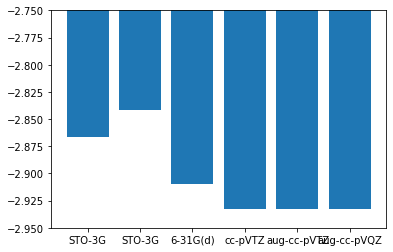

In [16]:
plt.bar(
    [1,2,3,4,5,6],
    [-2.8669283534318275,-2.8418364990824458,-2.9098394146425748,-2.9322482557926945,-2.9322713663802804,-2.932878077558255],
    tick_label=['STO-3G','STO-3G','6-31G(d)','cc-pVTZ','aug-cc-pVTZ','aug-cc-pVQZ']
)

plt.ylim(-2.95, -2.75)

## Molecular orbitals

Let's consider the shape of the molecular orbtials and electron density for this molecule along the bond length.

In [17]:
C = np.matmul(X,Cprime)
P = np.array([[ 1.28614168,0.54017322],
 [ 0.54017322 ,0.22687011]])

x = np.linspace(-8,8,num=1000)
r1 = abs(x+R/2)
r2 = abs(x-R/2)

psi_CGF_STO3G_He = Coeff[2,0]*(2*Expon[2,0]/np.pi)**(0.75)*np.exp(-Expon[2,0]*r1**2) \
                + Coeff[2,1]*(2*Expon[2,1]/np.pi)**(0.75)*np.exp(-Expon[2,1]*r1**2) \
                + Coeff[2,2]*(2*Expon[2,2]/np.pi)**(0.75)*np.exp(-Expon[2,2]*r1**2)
        
psi_CGF_STO3G_H = Coeff[2,0]*(2*Expon[2,0]/np.pi)**(0.75)*np.exp(-Expon[2,0]*r2**2) \
                + Coeff[2,1]*(2*Expon[2,1]/np.pi)**(0.75)*np.exp(-Expon[2,1]*r2**2) \
                + Coeff[2,2]*(2*Expon[2,2]/np.pi)**(0.75)*np.exp(-Expon[2,2]*r2**2)

density = np.zeros(x.shape)
        
density = density + P[0,0]*psi_CGF_STO3G_He*psi_CGF_STO3G_He
density = density + P[1,1]*psi_CGF_STO3G_H*psi_CGF_STO3G_H
density = density + 2*P[0,1]*psi_CGF_STO3G_He*psi_CGF_STO3G_H

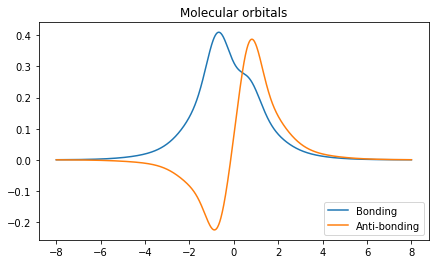

In [19]:
plt.figure(figsize=(7,4))
plt.title("Molecular orbitals")

plt.plot(x,C[0,0]*psi_CGF_STO3G_He+C[1,0]*psi_CGF_STO3G_H,label="Bonding")
plt.plot(x,C[0,1]*psi_CGF_STO3G_He+C[1,1]*psi_CGF_STO3G_H,label="Anti-bonding")
plt.legend(loc=4)

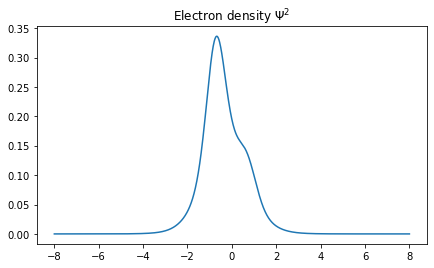

In [20]:
plt.figure(figsize=(7,4))
plt.title("Electron density $\Psi^{2}$")
plt.plot(x,density)